# Get Up And Running With XGBoost In R
By James Marquez, April 30, 2017

The goal of this article is to quickly get you running XGBoost on any classification problem and measuring its performance. It won't explain feature engineering, model tuning, or the theory or math behind the algorithm. There's already a plethoral of free resources to learn those elements. In my opinion, I learn better when I run my data through an algorithm and then use various resources to learn how to improve my prediction performance.

## Loading The  Dataset
We'll be using the popular [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data) dataset from [Kaggle](https://www.kaggle.com/) where we'll be predicting which passengers survived the sinking of the Titanic. You can download and learn all about the dataset from the provided link. We're going to load <span class="ic">train.csv</span> and split it into a <span class="ic">train</span> and <span class="ic">test</span> set. We'll train the model on our <span class="ic">train</span> set with the known outcomes and then test the model's performance on the <span class="ic">test</span> set with unknown outcomes.

In [1]:
# Load the dataset into our environment
mydata <- read.csv('/Users/JamesMarquezDev/Downloads/train.csv')

# Select and rearrange the order of the features we'll be using
mydata <- mydata[, c('Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin')]

# Convert the Pclass feature to an ordered factor 1 < 2 < 3
mydata$Pclass <- factor(mydata$Pclass, ordered=TRUE)

str(mydata) # View the structure of our dataset
head(mydata) # View the first six rows of the dataset

'data.frame':	891 obs. of  9 variables:
 $ Survived: int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass  : Ord.factor w/ 3 levels "1"<"2"<"3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age     : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare    : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked: Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...
 $ Cabin   : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...


Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin
0,3,male,22,1,0,7.2500,S,
1,1,female,38,1,0,71.2833,C,C85
1,3,female,26,0,0,7.9250,S,
1,1,female,35,1,0,53.1000,S,C123
0,3,male,35,0,0,8.0500,S,
0,3,male,NA,0,0,8.4583,Q,


## Finding Missing Data
Before we split our dataset into a <span class="ic">train</span> and <span class="ic">test</span> set, we must deal with missing data. We'll find every feature with missing data and simply remove those rows for simplicity sake.

In [2]:
sapply(mydata, function(x) sum(is.na(x)))

Survived   Pclass      Sex      Age    SibSp    Parch     Fare Embarked 
       0        0        0      177        0        0        0        0 
   Cabin 
       0

The <span class="ic">Age</span> feature is missing 177 observations so we'll simply remove those rows altogether.

In [3]:
# Get all rows that are not NA in the Age feature
mydata <- subset(mydata, !is.na(Age))

## Splitting The Dataset Into Train And Test Sets
Now, we're ready to split our dataset into a <span class="ic">train</span> set (75%) and <span class="ic">test</span> set (25%). We'll be using the really great [caret](http://topepo.github.io/caret/index.html) package to perform the split.

In [5]:
# Load the caret package
library(caret)

# Set the seed to create reproducible train and test sets
set.seed(300)

# Create a stratified random sample to create train and test sets
# Reference the outcome variable
trainIndex   <- createDataPartition(mydata$Survived, p=0.75, list=FALSE, times=1)
train        <- mydata[ trainIndex, ]
test         <- mydata[-trainIndex, ]

# Create separate vectors of our outcome variable for both our train and test sets
# We'll use these to train and test our model later
train.label  <- train$Survived
test.label   <- test$Survived

## One-hot Encoding
XGBoost requires your dataset to be a sparse matrix, which is a memory-efficient way to represent a large dataset that holds many zeros. We're going to use the [Matrix](https://cran.r-project.org/web/packages/Matrix/Matrix.pdf) package to convert our data frame to a sparse matrix and all our factored (categorical) features into dummy variables in one step.

In [7]:
# Load the Matrix package
library(Matrix)

# Create sparse matrixes and perform One-Hot Encoding to create dummy variables
dtrain  <- sparse.model.matrix(Survived ~ .-1, data=train)
dtest   <- sparse.model.matrix(Survived ~ .-1, data=test)

# View the number of rows and features of each set
dim(dtrain)
dim(dtest)

[1] 536 158

[1] 178 158

## Training The Model
For simplicity sake, we'll use the below hyperparameters, but you can improve the performance of your model by tuning them using the [caret](http://topepo.github.io/caret/index.html) package. We're using <span class="ic">objective = "binary:logistic"</span> because this is a logistic regression for binary classification problem. We're also using <span class="ic">eval_metrix = "error"</span> which is used for classification problems. You can learn about all available options here [XGBoost](https://cran.r-project.org/web/packages/xgboost/xgboost.pdf).

In [8]:
# Load the XGBoost package
library(xgboost)

# Set our hyperparameters
param <- list(objective   = "binary:logistic",
              eval_metric = "error",
              max_depth   = 7,
              eta         = 0.1,
              gammma      = 1,
              colsample_bytree = 0.5,
              min_child_weight = 1)

set.seed(1234)

# Pass in our hyperparameteres and train the model 
system.time(xgb <- xgboost(params  = param,
                           data    = dtrain,
                           label   = train.label, 
                           nrounds = 500,
                           print_every_n = 100,
                           verbose = 1))

[1]	train-error:0.149254 
[101]	train-error:0.052239 
[201]	train-error:0.029851 
[301]	train-error:0.016791 
[401]	train-error:0.013060 
[500]	train-error:0.009328 


   user  system elapsed 
  0.419   0.009   0.432 

## Evaluate The Model's Performance With A Confusion Matrix
The Confusion Matrix provides us with a large amount of information regarding the performance of our model. But first, we must choose a threshold. The threshold value is the cutoff at which we determine a positive prediction and a negative prediction. Down below, we have chosen 0.34 as our cutoff threshold. The model produces a probability for each prediction and we convert it to either a 1 (Survived) if the probability is above or equal to 0.86 and a 0 (Did Not Survive) if the probability is below 0.86.

In [9]:
# Create our prediction probabilities
pred <- predict(xgb, dtest)

# Set our cutoff threshold
pred.resp <- ifelse(pred >= 0.86, 1, 0)

# Create the confusion matrix
confusionMatrix(pred.resp, test.label, positive="1")

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 97 18
         1  6 57
                                          
               Accuracy : 0.8652          
                 95% CI : (0.8061, 0.9117)
    No Information Rate : 0.5787          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.7173          
 Mcnemar's Test P-Value : 0.02474         
                                          
            Sensitivity : 0.7600          
            Specificity : 0.9417          
         Pos Pred Value : 0.9048          
         Neg Pred Value : 0.8435          
             Prevalence : 0.4213          
         Detection Rate : 0.3202          
   Detection Prevalence : 0.3539          
      Balanced Accuracy : 0.8509          
                                          
       'Positive' Class : 1               
                                          

Without creating new features or tuning our hyperparameters, we were able to get a 76% true positive rate and a 94% true negative rate with a Kappa score of 0.7173.

## Determine Which Features Are Most Important
Now, we can view which features had the greatest impact on predictive performance.

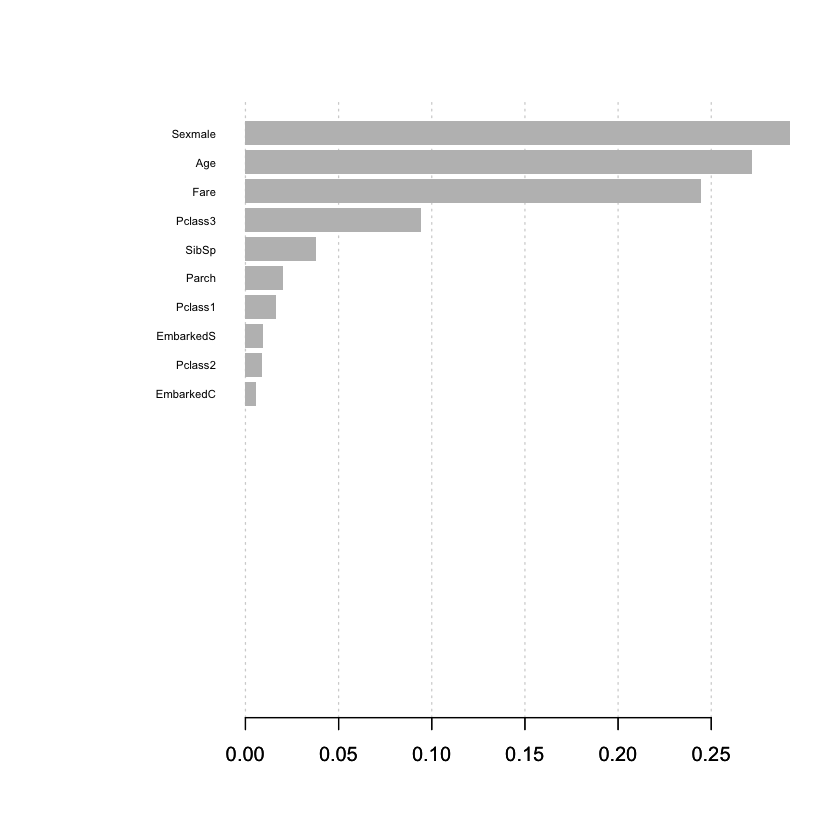

In [10]:
# Get the trained model
model <- xgb.dump(xgb, with_stats=TRUE)

# Get the feature real names
names <- dimnames(dtrain)[[2]]

# Compute feature importance matrix
importance_matrix <- xgb.importance(names, model=xgb)[0:20] # View top 20 most important features

# Plot
xgb.plot.importance(importance_matrix)

## Plotting The ROC To View Various Thresholds
An ROC curve allows us to visualize our model's performance when selecting different thresholds. The threshold value is indicated by the dots on the curved line. Each dot lets us view the average true positive rate and average false positive rate for each threshold. As the threshold value gets lower, the average true positive rate gets higher. However, the average false positive rate gets higher as well. It's important to select a threshold that provides an acceptable true positive rate while also limiting the false positive rate. You can read more at https://en.wikipedia.org/wiki/Receiver_operating_characteristic.

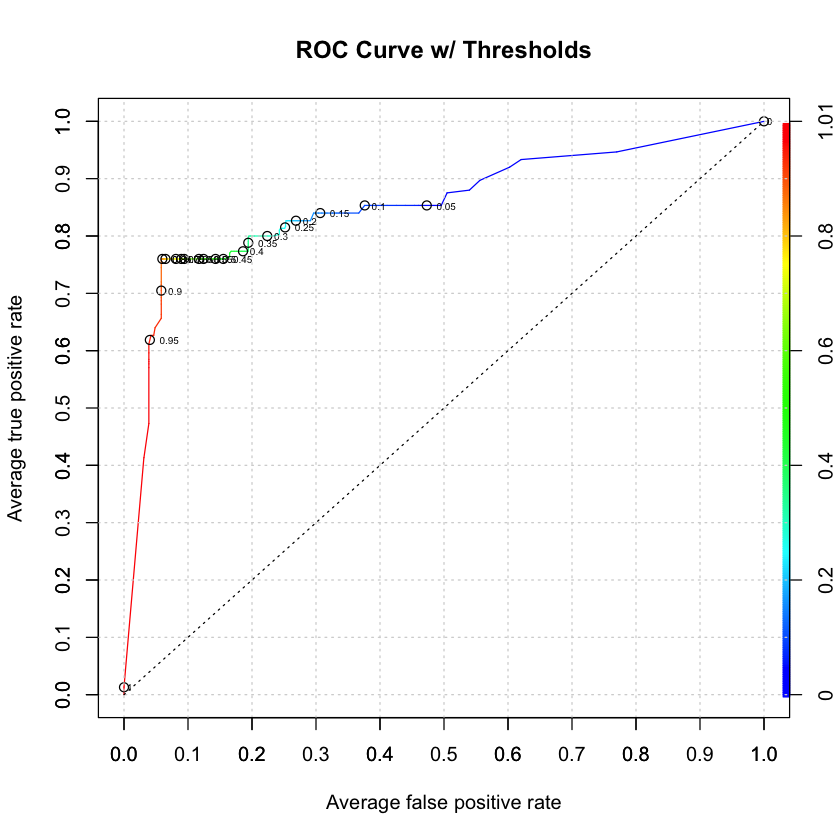

In [12]:
library(ROCR)

# Use ROCR package to plot ROC Curve
xgb.pred <- prediction(pred, test.label)
xgb.perf <- performance(xgb.pred, "tpr", "fpr")

plot(xgb.perf,
     avg="threshold",
     colorize=TRUE,
     lwd=1,
     main="ROC Curve w/ Thresholds",
     print.cutoffs.at=seq(0, 1, by=0.05),
     text.adj=c(-0.5, 0.5),
     text.cex=0.5)
grid(col="lightgray")
axis(1, at=seq(0, 1, by=0.1))
axis(2, at=seq(0, 1, by=0.1))
abline(v=c(0.1, 0.3, 0.5, 0.7, 0.9), col="lightgray", lty="dotted")
abline(h=c(0.1, 0.3, 0.5, 0.7, 0.9), col="lightgray", lty="dotted")
lines(x=c(0, 1), y=c(0, 1), col="black", lty="dotted")

That's it. Please leave a comment if you have any questions, spot any errors, or if you know of any other packages or graphs to display correlation matrices. You can grab the notebook from my GitHub here correlation_matrices_in_r.ipynb. Thanks for reading!